In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]
ohe = OneHotEncoder()

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_raw = train_data['data']
Y_raw = train_data['target']
Y_raw_oh = np.array(list(map(lambda x : encoder.transform(x), Y_raw)))


X_final_test = test_data['data']

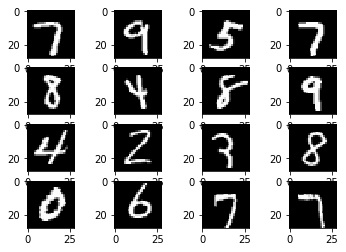

In [38]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, (X_test_norm).shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [113]:
# Подготовка датасета
from sklearn.model_selection import train_test_split
Xm = np.mean(X_raw, axis=0)
Xs = np.std(X_raw, axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X_raw, Y_raw, test_size=0.33, random_state=42)

#перевод в onehot
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))
Y_test_oh = np.array(list(map(lambda x : encoder.transform(x), Y_test)))

#нормирование данных
X_train_norm = (X_train - Xm)/(Xs + 0.01)
X_test_norm = (X_test - Xm) / (Xs + 0.01)
X_final_test_norm = (X_final_test - Xm)/(Xs + 0.01)

In [114]:
# Определение слоев сети
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.db = self.db - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [115]:
#определение функций активации

class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return lr*dz

class Softmax:
    
    def forward(self, x):
        self.x = x
        return np.exp(x)/np.sum(np.exp(x), axis=0)
    
    def backward(self, dz, lr=0.001):
        kroneker = np.identity(dz.size)
        a = np.exp(self.x)/np.sum(np.exp(self.x), axis=0)
        matrix = np.zeros((dz.size, dz.size))
        for i in range(dz.size):
            for k in range(dz.size):
                matrix[i][k] = a[i]*(kroneker[i][k]-a[k])
        return lr*matrix.dot(dz)

In [116]:
#кросс-энтропия
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return np.sum(-y_true*np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return -lr*self.y_true/self.y_hat*dz

In [145]:
# Опеределение самой сети
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 28, rlambda)
        self.m = Max()
        self.d2 = Dense(28, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [149]:
# Здесь процедура обучения
net = MnistNet(1e-5)
loss = CrossEntropy()
lr = 1e-1
L_train = []
acc_train = []
L_test = []
acc_test = []
n_iter = 0
for iter in range(100):
    L_acc = 0.
    sh = list(range(X_train_norm.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train_norm.shape[0]):
        x = X_train_norm[sh[i]]
        y = Y_train_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= Y_train_oh.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test_norm[i]
        y = Y_test_oh[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    acc_train.append(compute_acc(X_train_norm, Y_train, net))
    acc_test.append(compute_acc(X_test_norm, Y_test, net))
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

0 iter loss. Train : 0.8081517509782419 . Test : 0.4249291972245329
1 iter loss. Train : 0.3662524175622146 . Test : 0.3264926768436943
2 iter loss. Train : 0.29035393622101735 . Test : 0.28546358141150696
3 iter loss. Train : 0.25118342319448356 . Test : 0.26033835639256
4 iter loss. Train : 0.22517954779948055 . Test : 0.2438732354292874
5 iter loss. Train : 0.20645079784054435 . Test : 0.23201083064140712
6 iter loss. Train : 0.19205889166197196 . Test : 0.22198809616978726
7 iter loss. Train : 0.17968881962144795 . Test : 0.2140867621160424
8 iter loss. Train : 0.16992170570784443 . Test : 0.20681935317061495
9 iter loss. Train : 0.16127207489048806 . Test : 0.20078667104654416
10 iter loss. Train : 0.1537055730648148 . Test : 0.19598564743932603
11 iter loss. Train : 0.14752880200445231 . Test : 0.19006256626570464
12 iter loss. Train : 0.14202808049370913 . Test : 0.18688690344137562
13 iter loss. Train : 0.1370575571539357 . Test : 0.18371379649726355
14 iter loss. Train : 0.132

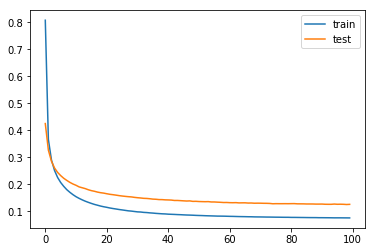

In [150]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")
plt.legend(loc='best')

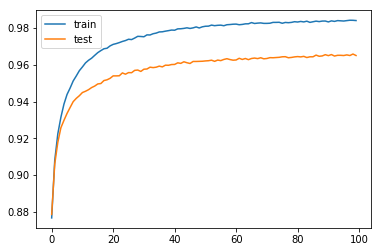

In [151]:
#подсчет точности
plt.plot(acc_train, label="train")
plt.plot(acc_test, label="test")
plt.legend(loc='best')

In [152]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_final_test_norm, net)